<a href="https://colab.research.google.com/github/kmntanda/collect/blob/master/Chest_Opacities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
# Import necessary libraries
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, layers
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2 as cv

sns.set()

2023-05-20 09:23:37.471359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 09:23:38.095289: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-20 09:23:38.095330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-20 09:23:38.095335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Custom Plot

In [ ]:
from PIL import Image
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
def plot_metrics(metrics):
  '''
  Plots model metrics
  '''

  for idx, metric in enumerate(metrics):
    plt.plot(model.history.epoch, model.history.history[metric], color='blue', label=metric)
    plt.plot(model.history.epoch, model.history.history[f'val_{metric}'], color='green', label=f'val_{metric}')
    plt.xlabel('epochs')
    plt.ylabel(metric)
    plt.title(f'Train {metric} vs. Validation {metric}')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y_true, y_pred, labels=None):
  '''
  Generates and displays a confusion matrix
  '''
  matrix = confusion_matrix(y_true, y_pred)

  cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)

  plt.figure(figsize=(8,8))
  plt.title(f"Confusion Matrix")
  cm_display.plot(ax=plt.subplot(), colorbar=False)
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

def plot_auc(labels, classification):

  if classification == 'binary':
    RocCurveDisplay.from_predictions(labels, y_pred)
    plt.plot([0,1],[0,1],'k:',label='Random')
    plt.show()

  if classification == 'multi-class':
    plt.figure(figsize=(7,5))
    plt.plot([0,1],[0,1],'k:',label='Random')

    for label in range(num_classes):
      fpr,tpr,thresholds = roc_curve(labels[:,label], y_pred[:,label])
      roc_auc = roc_auc_score(labels[:,label], y_pred[:,label])

      # Plot the results
      plt.plot(fpr, tpr, label='ROC curve for class {0} (AUC = {1:0.2f})'.format(class_names[label], roc_auc))
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.grid()
      plt.legend()
      plt.title(f'Class-wise AUROC metrics')

In [ ]:
import matplotlib.cm as mcm

def make_gradcam_heatmap(img_idx, model, last_conv_layer_name, pred_index=None):
  img_array = tf.convert_to_tensor(np.expand_dims(test_images[img_idx], axis=0), dtype=tf.float32)

  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  # Remove last layer's softmax
  model.layers[-1].activation = None
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(preds, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def display_gradcam(img_idx, alpha=0.002):
    # Prepare image
    img = test_images[img_idx]
    img_tensor = tf.convert_to_tensor(np.expand_dims(test_images[img_idx], axis=0), dtype=tf.float32)

    # Rescale heatmap  and image to a range 0-255
    last_conv_layer_name = 'conv5_block16_concat'
    heatmap = make_gradcam_heatmap(img_idx=img_idx, model=grad_model, last_conv_layer_name=last_conv_layer_name)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mcm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.clip_by_value(superimposed_img, 0.0, 1.0)

    # Get the top predicted class is
    preds = model(img_tensor)
    expected = int(test_labels[img_idx])

    ax = plt.subplot(2, 4, i+1)
    plt.title(f"Predicted: {class_names[tf.squeeze(tf.cast(tf.round(tf.nn.sigmoid(preds)), tf.int32)).numpy()]}\nExpected: {class_names[expected]}\nConfidence: {np.round(tf.nn.sigmoid(preds).numpy(), 4)[0]}")
    plt.imshow(superimposed_img)
    plt.axis('off')

In [ ]:
import random

def get_saliency_map(img_idx):
  # get the image
  image = test_images[img_idx]

  # add a batch dimension in front
  img = np.expand_dims(image, axis=0)
  expected_output = np.expand_dims(test_labels[img_idx], axis=0)

  with tf.GradientTape() as tape:
      # covert to tensor
      inputs = tf.convert_to_tensor(img, dtype=tf.float32)

      # watch the input pixels
      tape.watch(inputs)

      # generate the predictions
      prediction = model(inputs)

      # get the loss
      loss = tf.keras.losses.binary_crossentropy(
          expected_output, prediction, from_logits=True
      )

  # get the gradient with respect to the inputs
  gradients = tape.gradient(loss, inputs)

  # reduce the RGB image to grayscale
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)

  # normalize the pixel values to be in the range [0, 255].
  # the max value in the grayscale tensor will be pushed to 255.
  # the min value will be pushed to 0.
  normalized_tensor = tf.cast(
      255
      * (grayscale_tensor - tf.reduce_min(grayscale_tensor))
      / (tf.reduce_max(grayscale_tensor) - tf.reduce_min(grayscale_tensor)),
      tf.uint8,
  )

  # remove the channel dimension to make the tensor a 2d tensor
  normalized_tensor = tf.squeeze(normalized_tensor)

  gradient_color = cv.applyColorMap(normalized_tensor.numpy(), cv.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  super_imposed = cv.addWeighted(image, 0.5, gradient_color.astype(np.float32), 0.5, 0.0)
  super_imposed = np.clip(super_imposed, 0, 1)

  ax = plt.subplot(2, 4, i+1)
  plt.title(f"Confidence: {np.round(tf.nn.sigmoid(prediction).numpy(), 4)[0]}")
  plt.imshow(super_imposed)
  plt.axis('off')

# Custom Metrics

In [ ]:
from tensorflow.keras.metrics import TrueNegatives, FalsePositives

# Instantiate metric objects
tn = TrueNegatives(thresholds=0)
fp = FalsePositives(thresholds=0)

def tnr(y_true, y_pred):
  """
  Function that calculates and returns specificity a.k.a true negative rate
  """

  def true_negatives(y_true, y_pred):
    """
    Function that calculates and returns true negatives
    """
    tn.update_state(y_true, y_pred)
    return tn.result()
  
  def false_positives(y_true, y_pred):
    """
    Function that calculates and returns false positives
    """
    fp.update_state(y_true, y_pred)
    return fp.result()
  
  true_negatives = true_negatives(y_true, y_pred)
  false_positives = false_positives(y_true, y_pred)

  result = tf.math.divide_no_nan(
      true_negatives,
      tf.math.add(false_positives, true_negatives),
      )

  return result

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

# Instantiate precision and recall metric objects
p = Precision(thresholds=0)
r = Recall(thresholds=0)

def f1_score(y_true, y_pred):
  """
  Function that calculates and returns
  f1_score using Precision and Recall
  """

  def precision(y_true, y_pred):
    """
    Function that calculates and returns precision
    """
    p.update_state(y_true, y_pred)
    return p.result()
  
  def recall(y_true, y_pred):
    """
    Function that calculates and returns recall
    """
    r.update_state(y_true, y_pred)
    return r.result()
  
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)

  result = tf.math.multiply_no_nan(
      tf.constant(2, tf.float32),
      tf.math.divide_no_nan(
          tf.math.multiply_no_nan(
              precision,
              recall
          ),
          tf.math.add(
              precision,
              recall
          )
      )
  )

  return result

# Augmentation

In [ ]:
def transform(img, seed):
  fill = tf.constant(0)

  img_shape = img.shape
  img = tf.squeeze(img)

  #Random flip
  img = tf.image.stateless_random_flip_left_right(img, seed=seed)

  #Create translation vector
  tx = tf.random.stateless_uniform((), minval=-0.02, maxval=0.02, seed=seed)
  ty = tf.random.stateless_uniform((), minval=-0.02, maxval=0.02, seed=seed)

  if tf.random.stateless_uniform((), seed=seed) < 0.5:
    img = tfa.image.translate_xy(img, [tx,ty], fill)

  #Enforce shape consistency
  img = tf.expand_dims(img, 0)
  img.set_shape(img_shape)

  return img

In [ ]:
def denoise(img):
  img_shape = img.shape
  img = tf.squeeze(img)

  img = img.numpy().astype(np.uint8)
  img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  contrast = np.random.uniform(0.9,1.1)
  clahe = cv.createCLAHE(clipLimit=contrast, tileGridSize=(8,8))
  img = clahe.apply(img)
  img = cv.fastNlMeansDenoising(img,None,7,7,21)
  img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
  img = tf.convert_to_tensor(img, dtype=tf.float32)

  img = tf.expand_dims(img, 0)
  img.set_shape(img_shape)

  return img

def add_noise(img):

  img_shape = img.shape
  img = tf.squeeze(img)

  img = img.numpy().astype(np.uint8)
  img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  gauss_noise = np.zeros((size,size),dtype=np.uint8)
  mean = np.random.choice(range(60, 70), 1)
  std = np.random.choice(range(6,16), 1)
  cv.randn(gauss_noise,mean,std)
  gauss_noise = (gauss_noise*0.5).astype(np.uint8)
  img = cv.add(img,gauss_noise)
  img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
  img = tf.convert_to_tensor(img, dtype=tf.float32)

  img = tf.expand_dims(img, 0)
  img.set_shape(img_shape)

  return img

In [ ]:
@tf.function
def aug(img):
  seed = rng.make_seeds()[:,0]

  img = transform(img, seed)

  if tf.random.stateless_uniform((), seed=seed) < 0.5:
    img = tf.py_function(denoise, [img], tf.float32)
  else:
    img = tf.py_function(add_noise, [img], tf.float32)

  img = tf.reshape(img, (1,size,size,channels))

  return img

# Global variables

In [ ]:
#Define global variables
size = 224
channels = 3
image_size = (size,size)
image_shape = (size,size,channels)
batch_size = 64
rng = tf.random.Generator.from_seed(42, alg='philox')

# Data prep

In [ ]:
dir = '/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/dataset1/known_images'
classes = ['normal', 'sick']
classes_map = dict(zip(classes,range(len(classes))))
class_dict = {key:len(glob.glob(f'{dir}/{key}/*.png')) for key in classes}

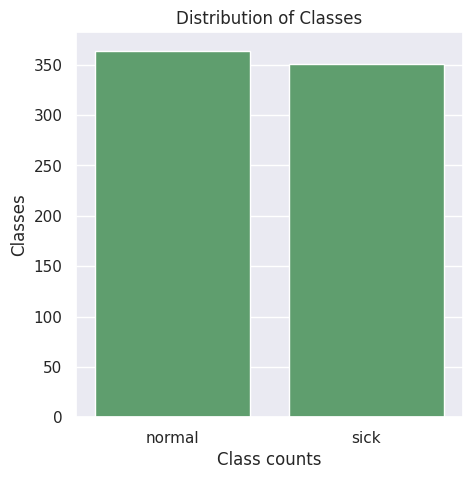

In [ ]:
# Plot class distribution

plt.figure(figsize=(5,5))
sns.barplot(y=list(class_dict.values()), x=list(class_dict.keys()), color='g')
plt.title('Distribution of Classes')
plt.xlabel('Class counts')
plt.ylabel('Classes')
plt.show()

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                       validation_split=0.3,
                                                       subset="training",
                                                       seed=42,
                                                       image_size=image_size,
                                                       interpolation='bicubic',
                                                       color_mode='rgb',
                                                       batch_size=batch_size,
                                                       label_mode='binary',
                                                       labels='inferred',
                                                       crop_to_aspect_ratio=False,
                                                       )

val_ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                     validation_split=0.3,
                                                     subset="validation",
                                                     seed=42,
                                                     image_size=image_size,
                                                     interpolation='bicubic',
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     label_mode='binary',
                                                     labels='inferred',
                                                     crop_to_aspect_ratio=False,
                                                     )

Found 715 files belonging to 2 classes.
Using 501 files for training.
Found 715 files belonging to 2 classes.
Using 214 files for validation.


In [ ]:
import re
class_names = train_ds.class_names
alpha = len([path for path in train_ds.file_paths if re.split('/', path)[-2] == 'normal']) / len(train_ds.file_paths)

In [ ]:
train_aug_ds1 = train_ds.rebatch(1).map(lambda x, y: (aug(x), y)).rebatch(batch_size)
train_aug_ds2 = train_ds.rebatch(1).map(lambda x, y: (aug(x), y)).rebatch(batch_size)
train_ds = train_ds.concatenate(train_aug_ds1).concatenate(train_aug_ds2).rebatch(1).shuffle(batch_size * 100).rebatch(batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
normalizer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalizer(x), y))
val_ds = val_ds.map(lambda x, y: (normalizer(x), y))

In [ ]:
train_ds = train_ds.map(lambda x, y: (tf.image.per_image_standardization(x), y))
val_ds = val_ds.map(lambda x, y: (tf.image.per_image_standardization(x), y))

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

# Models

In [ ]:
# Insantiate early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_tpr',
                                        patience=10,
                                        start_from_epoch=20,
                                        mode='max',
                                        restore_best_weights=True
                                        )

In [ ]:
# Instantiate base model
pre_trained_model = DenseNet121(input_shape=image_shape,
                                include_top = False,
                                weights = 'imagenet',
                                )

# Freeze layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# Add pooling, dropout and dense layers
output = pre_trained_model.output
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(1024, 'relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(output)
output = layers.Dense(1)(output)

# Create model
model = Model(pre_trained_model.input, output)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss=tf.keras.losses.BinaryFocalCrossentropy(alpha=alpha, gamma=1.3, from_logits=True, apply_class_balancing=True, label_smoothing=0.1), 
              metrics=[f1_score, 
                       tf.metrics.TruePositives(name='tp', thresholds=0), 
                       tf.metrics.FalseNegatives(name='fn', thresholds=0), 
                       tf.keras.metrics.Recall(name='tpr', thresholds=0), 
                       tnr, 
                       tf.keras.metrics.AUC(name='ap', curve='PR', from_logits=True), 
                       tf.keras.metrics.AUC(name='auc', curve='ROC', from_logits=True),
                       ]
              )

# Train model
model.fit(train_ds,
          validation_data=val_ds,
          epochs=200,
          callbacks=[early_stopping_callback],
          )

Epoch 1/200
24/24 [==============================] - 40s 332ms/step - loss: 0.1474 - f1_score: 0.5903 - tp: 471.0000 - fn: 243.0000 - tpr: 0.6597 - tnr: 0.4501 - ap: 0.6330 - auc: 0.6207 - val_loss: 0.1384 - val_f1_score: 0.5998 - val_tp: 70.0000 - val_fn: 43.0000 - val_tpr: 0.6195 - val_tnr: 0.5024 - val_ap: 0.7677 - val_auc: 0.7170
Epoch 2/200
24/24 [==============================] - 4s 150ms/step - loss: 0.1428 - f1_score: 0.6039 - tp: 455.0000 - fn: 259.0000 - tpr: 0.6373 - tnr: 0.5317 - ap: 0.6718 - auc: 0.6621 - val_loss: 0.1358 - val_f1_score: 0.6078 - val_tp: 68.0000 - val_fn: 45.0000 - val_tpr: 0.6018 - val_tnr: 0.5560 - val_ap: 0.7928 - val_auc: 0.7497
Epoch 3/200
24/24 [==============================] - 4s 150ms/step - loss: 0.1390 - f1_score: 0.6133 - tp: 455.0000 - fn: 259.0000 - tpr: 0.6373 - tnr: 0.5792 - ap: 0.7076 - auc: 0.6973 - val_loss: 0.1332 - val_f1_score: 0.6182 - val_tp: 69.0000 - val_fn: 44.0000 - val_tpr: 0.6106 - val_tnr: 0.5977 - val_ap: 0.8187 - val_auc: 0

# Evaluation

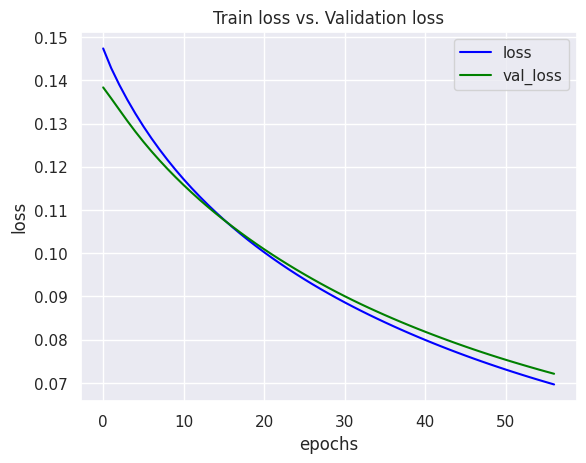

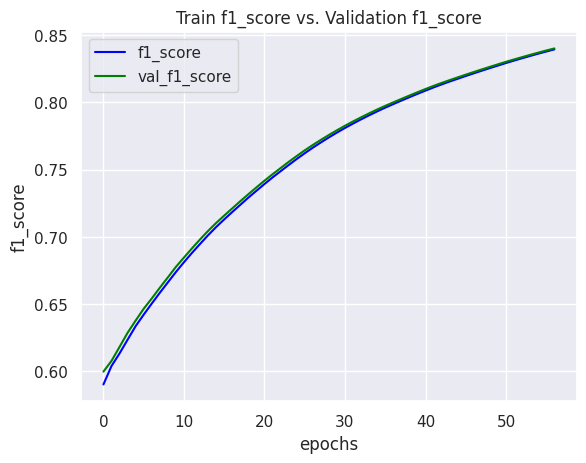

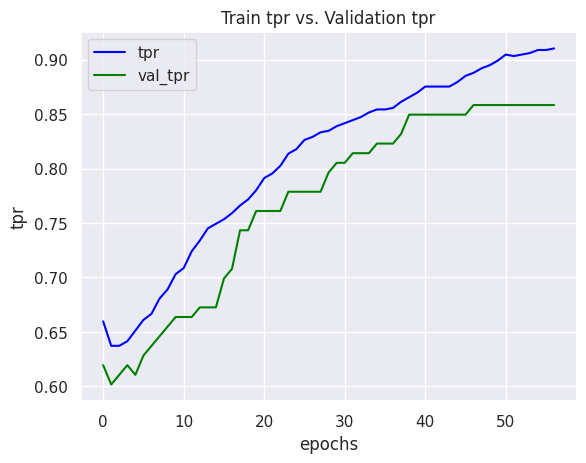

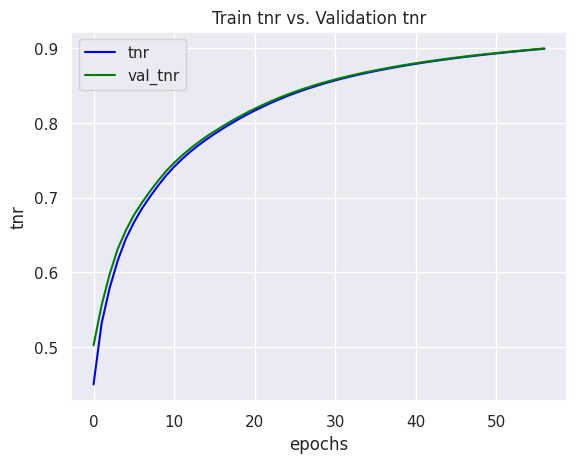

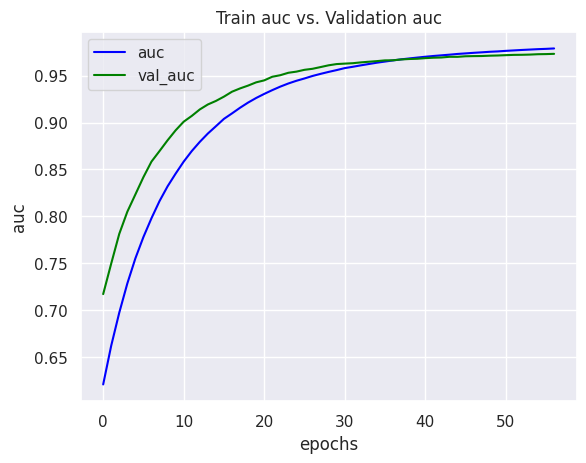

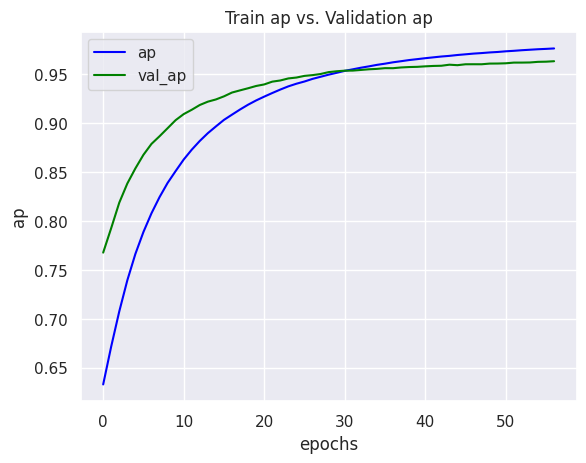

In [ ]:
plot_metrics(['loss', 'f1_score', 'tpr', 'tnr', 'auc', 'ap'])

In [ ]:
# Run inference
y_pred = model.predict(val_ds)
y_pred.shape

3/3 [==============================] - 1s 143ms/step


(143, 1)

In [ ]:
def unbatch_validation_images():
  '''
  Gets validation images from batches
  '''
  n_val_examples = y_pred.shape[0]

  #Unbatch validation dataset
  val = val_ds.unbatch()
  val = val.batch(batch_size=n_val_examples)

  val_images = []
  val_labels = []

  #Get validation images and labels
  for image, label in val.take(1):
    val_images = image.numpy()
    val_labels = label.numpy()

  return val_images, val_labels

In [ ]:
#Get validation images
val_images, val_labels = unbatch_validation_images()
val_labels.shape

(143, 1)

In [ ]:
# pred = pd.get_dummies(np.argmax(y_pred, axis=-1)).to_numpy().astype(np.float32)
pred = tf.round(tf.nn.sigmoid(y_pred)).numpy()
pred.shape

(143, 1)

In [ ]:
# Evaluate results
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced

print(classification_report(val_labels, pred, target_names=class_names))
print(classification_report_imbalanced(val_labels, pred, target_names=class_names))

              precision    recall  f1-score   support

      normal       0.90      0.93      0.91        69
        sick       0.93      0.91      0.92        74

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143

                   pre       rec       spe        f1       geo       iba       sup

     normal       0.90      0.93      0.91      0.91      0.92      0.84        69
       sick       0.93      0.91      0.93      0.92      0.92      0.84        74

avg / total       0.92      0.92      0.92      0.92      0.92      0.84       143



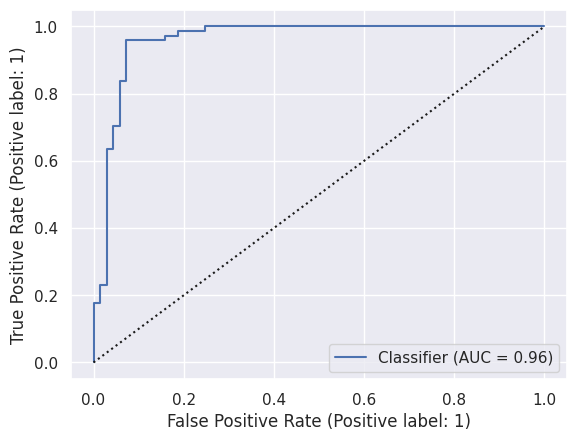

In [ ]:
plot_auc(labels=val_labels, classification='binary')

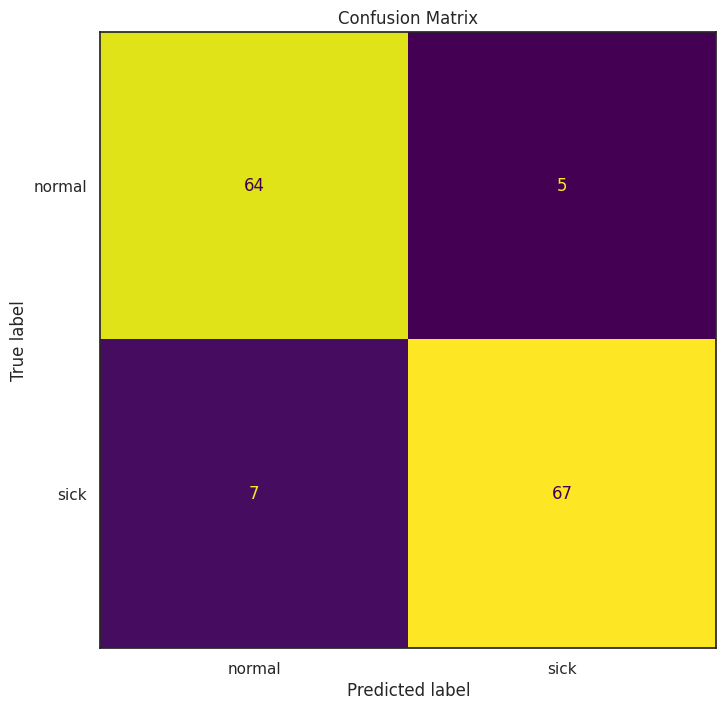

In [ ]:
# Plot confusion matrix
sns.set_theme(style="white", palette=None)
plot_cm(val_labels, pred, labels=class_names)

In [ ]:
# model.save('/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/model')

# Testing

In [ ]:
dir = '/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/dataset2/images'

In [ ]:
# get model
model = tf.keras.models.load_model('/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/model', custom_objects={'tnr':tnr})

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(dir,
                                                      seed=42,
                                                      image_size=image_size,
                                                      interpolation='bicubic',
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      label_mode='binary',
                                                      labels='inferred'
                                                      )

Found 223 files belonging to 2 classes.


In [ ]:
test_ds = test_ds.map(lambda x, y: (normalizer(x), y))
test_ds = test_ds.map(lambda x, y: (tf.image.per_image_standardization(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model.evaluate(test_ds)

4/4 [==============================] - 6s 528ms/step - loss: 0.2430 - tp: 99.0000 - fn: 13.0000 - tpr: 0.8839 - tnr: 0.2490 - ap: 0.5847 - auc: 0.6139


[0.24301990866661072,
 99.0,
 13.0,
 0.8839285969734192,
 0.2489686906337738,
 0.5846807360649109,
 0.6138996481895447]

In [ ]:
# Run inference
y_pred = model.predict(test_ds)
y_pred.shape

4/4 [==============================] - 2s 137ms/step


(223, 1)

In [ ]:
def unbatch_test_images():
  '''
  Gets test images from batches
  '''
  n_test_examples = y_pred.shape[0]

  #Unbatch test dataset
  test = test_ds.unbatch()
  test = test.batch(batch_size=n_test_examples)

  test_images = []
  test_labels = []

  #Get test images and labels
  for image, label in test.take(1):
    test_images = image.numpy()
    test_labels = label.numpy()

  return test_images, test_labels

In [ ]:
#Get test images
test_images, test_labels = unbatch_test_images()
test_labels.shape

(223, 1)

In [ ]:
pred = np.round(tf.nn.sigmoid(y_pred).numpy()).astype(np.float32)
pred.shape

(223, 1)

In [ ]:
# Evaluate results
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced

print(classification_report(test_labels, pred, target_names=class_names))
print(classification_report_imbalanced(test_labels, pred, target_names=class_names))

              precision    recall  f1-score   support

      normal       0.68      0.24      0.36       111
        sick       0.54      0.88      0.67       112

    accuracy                           0.57       223
   macro avg       0.61      0.56      0.51       223
weighted avg       0.61      0.57      0.52       223

                   pre       rec       spe        f1       geo       iba       sup

     normal       0.68      0.24      0.88      0.36      0.46      0.20       111
       sick       0.54      0.88      0.24      0.67      0.46      0.23       112

avg / total       0.61      0.57      0.56      0.52      0.46      0.22       223



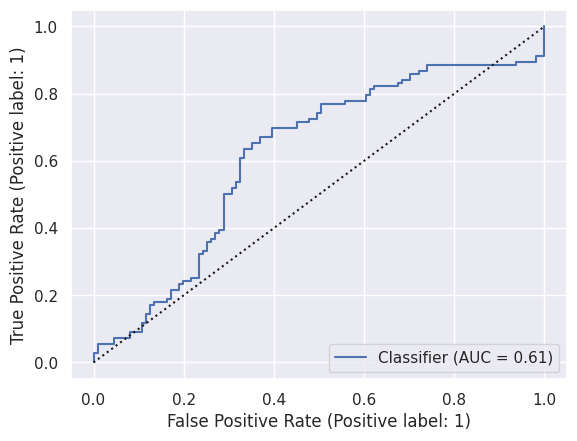

In [ ]:
plot_auc(labels=test_labels, classification='binary')

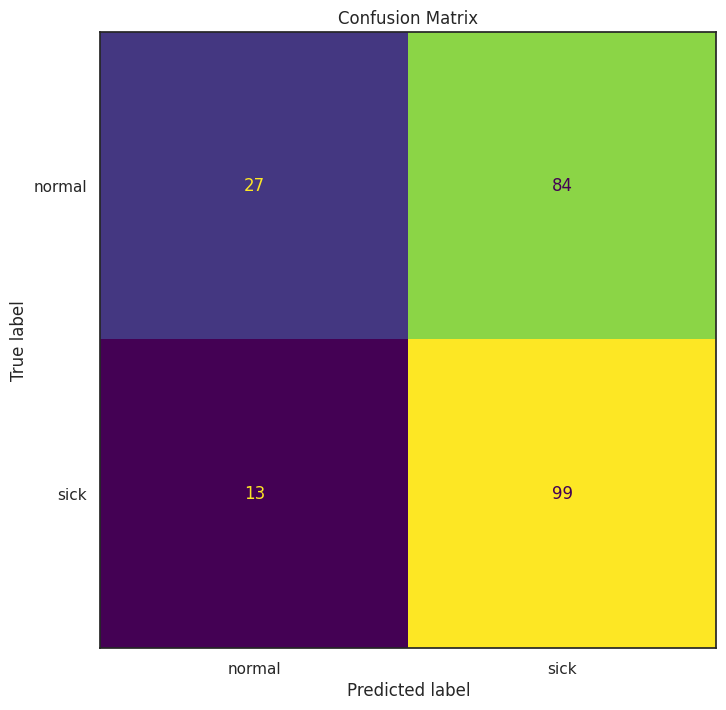

In [ ]:
# Plot confusion matrix
sns.set_theme(style="white", palette=None)
plot_cm(test_labels, pred, labels=class_names)

In [ ]:
eval_df = pd.DataFrame(data={'target': np.squeeze(test_labels).astype(np.int32),
                             'prediction': np.squeeze(pred).astype(np.int32)}
                       ).apply(lambda x: pd.Series(([class_names[x[0]], class_names[x[1]]])), axis=1).rename(columns={0:'target', 1:'prediction'})

correct_df = eval_df.where(eval_df.target == eval_df.prediction).dropna()
incorrect_df = eval_df.where(eval_df.target != eval_df.prediction).dropna()

print(f'{correct_df.shape[0]} correct predictions vs. {incorrect_df.shape[0]} incorrect predictions')

126 correct predictions vs. 97 incorrect predictions


In [ ]:
# get model
model = tf.keras.models.load_model('/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/model', custom_objects={'tnr':tnr})

In [ ]:
idxs = random.choices(correct_df.where(correct_df.target == 'sick').dropna().index.tolist(), k=8)

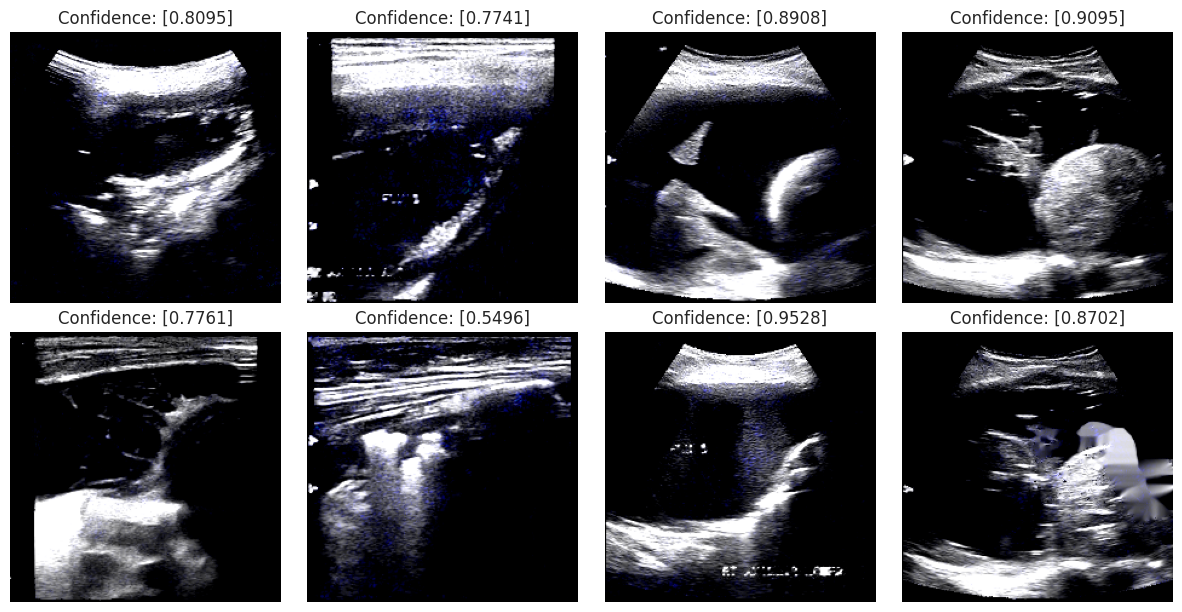

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  get_saliency_map(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.65)
plt.subplots_adjust(wspace=0.1)

In [ ]:
# get model
grad_model = tf.keras.models.load_model('/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/model', custom_objects={'tnr':tnr})

In [ ]:
idxs = random.choices(incorrect_df.where(incorrect_df.prediction == 'sick').dropna().index.tolist(), k=8)

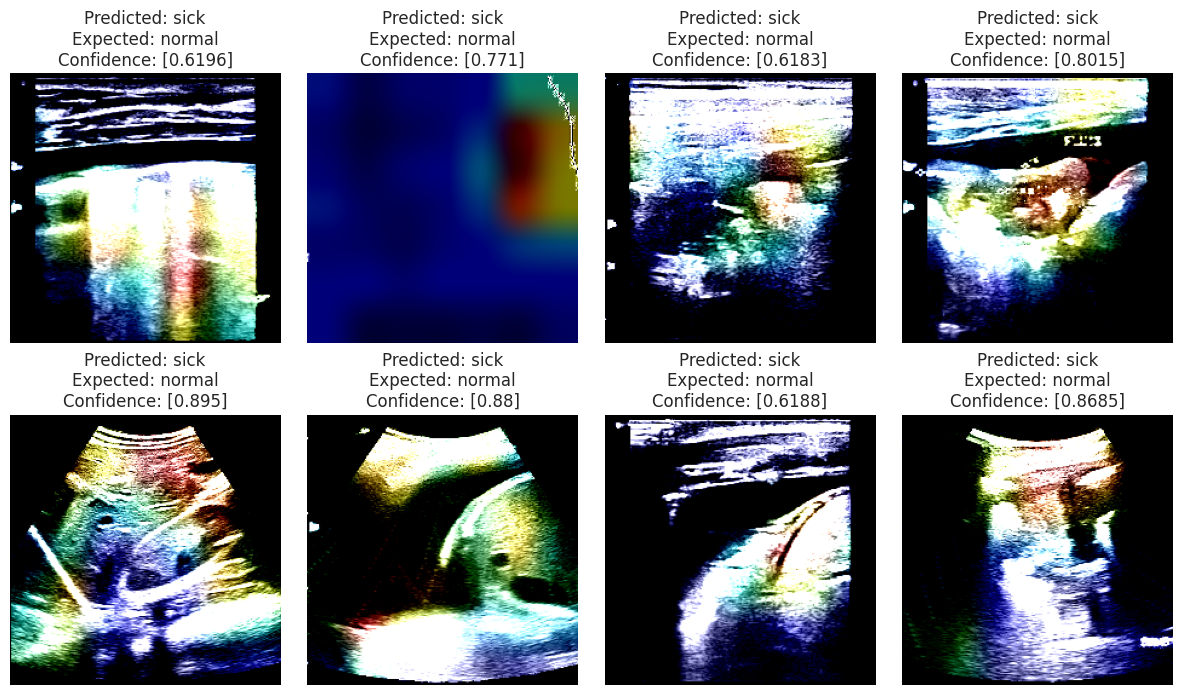

In [ ]:
plt.figure(figsize=(15, 15))

for i in range(len(idxs)):
  display_gradcam(img_idx=idxs[i])

plt.subplots_adjust(hspace=-0.58)
plt.subplots_adjust(wspace=0.1)

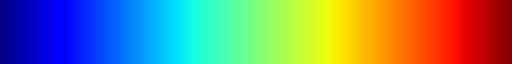

In [ ]:
mcm.jet

# Inference

In [ ]:
import os
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image

def preprocess(img):
  """
  Function that processes images for
  model prediction.
  """

  path = os.path.join(dir, img)
  x = image.load_img(path=path, target_size=(224,224))
  x = image.img_to_array(x)
  x = normalizer(x)
  x = tf.image.per_image_standardization(x)
  x = tf.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  return x

def decode(prediction):
  """
  Function that decodes model predictions.
  Returns class label with the highest probability.
  """
  pred = tf.cast(tf.squeeze(tf.round(tf.nn.sigmoid(prediction))), tf.int32).numpy()
  return class_names[pred]

In [ ]:
# get model
model = tf.keras.models.load_model('/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/model', custom_objects={'tnr':tnr})

In [ ]:
dir = '/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/dataset1/unknown_images'
img_names = os.listdir(dir)

In [ ]:
# Make predictions on test images
inference = map(preprocess, img_names)
class_probs = model.predict(inference)
class_preds = map(decode, class_probs)
final_result = np.array([img_names, list(class_preds)], dtype='object').T

# Create final submission csv file
submission = pd.DataFrame(data = final_result, columns = ['Image', 'Class'])
submission.to_csv( '/home/alvin/Documents/Masters/Deep Learning/deep_learning_project/deep_learning_project/results/submission.csv', index=False)

50/50 [==============================] - 1s 14ms/step
